# Analysis

This notebook provides an example of a full processing and analysis pipeline for a reduced dataset.

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [45]:
import logging
import os
import pprint
import matplotlib.pyplot as plt
from suite2p import default_ops, version
from IPython.utils import io
import numpy as np

from constants import *
from logger import logger
from fileops import get_data_folders, get_output_equivalent, loadtif, savetif
from parsers import parse_experiment_parameters
from stackers import stack_tifs
from viewers import view, dualview
from s2putils import run_suite2p, get_suite2p_data, view_registered_stack
from postpro import separate_trials, get_relative_fluorescence_change
from plotters import *
from filters import KalmanDenoiser

logger.setLevel(logging.INFO)

### General parameters

In [3]:
# Data directory 
rootdir = '../../data/yiyuan/raw/new_experiments_201911/' # Root directory for raw data
date = '11082019'
mouse = 'mouse6'
region = 'region1'
basedir = os.path.join(rootdir, date, mouse, region)

# Other options
overwrite = True  # overwrite behavior in case output files already exist (True, False, or '?')

## Tif merging

We start by merging individual tif files into a big stack tif file.

### Gather data folders

In [4]:
# Get raw list of subolders containing tifs 
datafolders = get_data_folders(basedir, exclude_patterns=['MIP', 'References'], include_patterns=['line3'])
logger.info(f'Identified data folders:\n{pprint.pformat(datafolders)}')

 15/10/2021 17:30:23: Identified data folders:
['../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_005MPA_50DC-756',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_05DC-748',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_50DC-743',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_06MPA_50DC-752',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_20DC-746',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_30DC-745',
 '../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100H

### Select a particular data folder

In [5]:
datafolder = datafolders[0]
logger.info(f'Selected data folder:\n{datafolder}')

 15/10/2021 17:30:23: Selected data folder:
../../data/yiyuan/raw/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749


### Parse experiment parameters

In [6]:
exp_params = parse_experiment_parameters(os.path.basename(datafolder))
logger.info(f'Experiments parameters:\n{pprint.pformat(exp_params)}')

 15/10/2021 17:30:23: Experiments parameters:
{'???': 100.0,
 'DC': 60.0,
 'P': 0.8,
 'duration': 0.2,
 'fps': 3.56,
 'line': 'line3',
 'run': 749,
 'trial_length': 100}


### Merge TIFs into stack

In [7]:
with io.capture_output() as captured:  # turning off warning upon TIF reading
    stack_fpath = stack_tifs(datafolder, overwrite=False)
stack = loadtif(stack_fpath)

 15/10/2021 17:30:23: "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 15/10/2021 17:30:23: loaded (1600, 256, 256) uint16 stack from "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"


### Visualize stack

 15/10/2021 17:30:27: stack size: (1600, 256, 256)
 15/10/2021 17:30:27: rendering stack view...


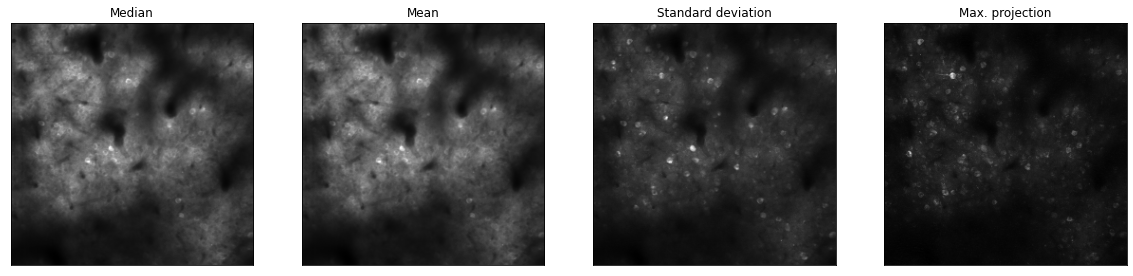

In [8]:
fig = plot_stack_summary(stack)
view(stack)

We notice a significant amount of Speckle noise in the acquired images, which must be removed.

## Denoising

Let's now use our Kalman filter implementation to denoise the raw TIF stack.

We recall here that our modified Kalman implementation offers the advantages that
- wrong guesses of the initial variance will not prevent noise estimation but merely delay the fitting process.
- an initial baseline padding is used to absorb this fitting process.

Hence, we will fix here default parameters for the variance (`V = 0.05`) and padding length (`n = 10`), and focus our analysis on the main parameter influencing the outcome of this processing step, i.e. the *specified filter gain* (`G`). Ideally, we would like to find the optimal value that efficiently removes Speckle noise while mainting details of transient activity. From collective experience, it seems that values around 0.5 work well when using GCaMP6s as a fluorescence reporter. We will therefore use this value to start with.

 15/10/2021 17:30:28: constructing 10-frames baseline from 100-frames stack...
 15/10/2021 17:30:29: filtering 1600-frames stack with KalmanDenoiser(gain=0.5, var=0.05, npad=10)


100%|██████████| 1609/1609 [00:01<00:00, 1042.15it/s]


 15/10/2021 17:30:34: "/Users/tlemaire/Documents/data/yiyuan/filtered/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif" already exists
 15/10/2021 17:30:34: saving (1600, 256, 256) uint16 stack as "/Users/tlemaire/Documents/data/yiyuan/filtered/new_experiments_201911/11082019/mouse6/region1/line3_100frames_100Hz_200ms_3.56Hz_08MPA_60DC-749.tif"...
 15/10/2021 17:30:34: stack size: (1600, 256, 256)
 15/10/2021 17:30:34: rendering stacks view...


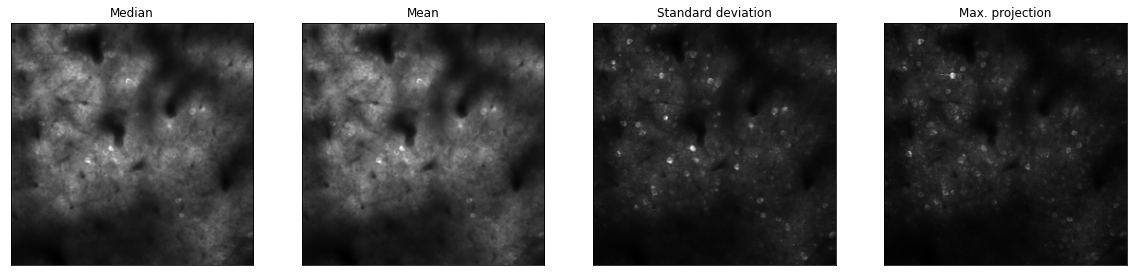

In [9]:
kd = KalmanDenoiser(G=0.5, V=0.05, npad=10)
filtered_stack = kd.filter(stack)
fig = plot_stack_summary(filtered_stack)
filtered_stack_fpath = get_output_equivalent(stack_fpath, 'stacked', 'filtered')
savetif(filtered_stack_fpath, filtered_stack, overwrite=overwrite)
dualview(stack, filtered_stack, title1='Raw', title2='Filtered', suptitle=kd)

## Functional segmentation

We will now use the suite2p pipeline to identify ROIs in our field of view and compute their fluorescence timecourse.

### Set suite2p pipeline parameters

In [10]:
# Custom options
myops = {
    'tau': TAU_GCAMP6_DECAY,  # timescale mof the sensor (in our case GCaMP6s)
    'fs': FPS,  # sampling rate (per plane)
    'reg_tif': True,  # whether or not to write the registered binary to tiff files
    'nonrigid': True,  # whether or not to perform non-rigid registration, which splits the field of view into blocks and computes registration offsets in each block separately.
    'denoise': True,  # perform PCA denoising of the registered stack prior to ROI detection 
}

ops = default_ops()  # get default run options
ops.update(myops)  # update with personal options
logger.info(f'Suite2p {version} with run options:\n{pprint.pformat(ops)}')

 15/10/2021 17:30:35: Suite2p 0.10.2 with run options:
{'1Preg': False,
 'align_by_chan': 1,
 'allow_overlap': False,
 'anatomical_only': 0,
 'aspect': 1.0,
 'baseline': 'maximin',
 'batch_size': 500,
 'bidi_corrected': False,
 'bidiphase': 0,
 'block_size': [128, 128],
 'bruker': False,
 'bruker_bidirectional': False,
 'cellprob_threshold': 0.0,
 'chan2_thres': 0.65,
 'classifier_path': 0,
 'combined': True,
 'connected': True,
 'delete_bin': False,
 'denoise': True,
 'diameter': 0,
 'do_bidiphase': False,
 'do_registration': 1,
 'fast_disk': [],
 'flow_threshold': 1.5,
 'force_refImg': False,
 'force_sktiff': False,
 'frames_include': -1,
 'fs': 3.56,
 'functional_chan': 1,
 'h5py': [],
 'h5py_key': 'data',
 'high_pass': 100,
 'ignore_flyback': [],
 'inner_neuropil_radius': 2,
 'keep_movie_raw': False,
 'lam_percentile': 50.0,
 'look_one_level_down': False,
 'max_iterations': 20,
 'max_overlap': 0.75,
 'maxregshift': 0.1,
 'maxregshiftNR': 5,
 'mesoscan': False,
 'min_neuropil_pixels

### Run suite2p

In [11]:
# Define input datasets
stack_fpaths = {'raw': stack_fpath, 'filtered': filtered_stack_fpath}
# Run suite2p for both raw and filtered datasets
output_ops = {} 
for k, inputfile in stack_fpaths.items():
    inputdir, _ = os.path.split(inputfile)
    output_ops[k] = run_suite2p(ops=ops, db={'data_path': [inputdir]}, overwrite=overwrite)
    print(set(output_ops[k].keys()).difference(ops.keys()))

/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/suite2p/plane0
 15/10/2021 17:30:35: suite2p output files already exist in "/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/suite2p/plane0"
{'data_path': ['/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1']}
FOUND BINARIES AND OPS IN ['/Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/suite2p/plane0/ops.npy']
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, plane already registered
binary path: /Users/tlemaire/Documents/data/yiyuan/stacked/new_experiments_201911/11082019/mouse6/region1/suite2p/plane0/data.bin
NOTE: applying default /Users/tlemaire/.suite2p/classifiers/classifier_user.npy
----------- ROI DETECTION
Binning movie in chunks of length 04
Binned movie [375,252,254] in 0.68 sec.
Binned movie denoised (for cell detection

/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_ipix' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/suite2p/extraction/extract.py", line 105:
@njit(parallel=True)
def matmul_traces(Fi, data, cell_ipix, cell_lam):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/opt/anaconda3/envs/suite2p/lib/python3.8/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'cell_lam' of function 'matmul_traces'.

For more information visit https://numba.pydata.org/numba-doc/latest/

Extracted fluorescence from 787 ROIs in 1600 frames, 4.05 sec.
----------- Total 5.39 sec.
----------- CLASSIFICATION
['npix_norm', 'skew', 'compact']
----------- Total 0.03 sec.
----------- SPIKE DECONVOLUTION
----------- Total 0.08 sec.
Plane 0 processed in 22.94 sec (can open in GUI).
total = 22.96 sec.
TOTAL RUNTIME 22.96 sec
{'date_proc', 'xrange', 'Lx', 'Vmap', 'timing', 'ops_path', 'yblock', 'corrXY1', 'yrange', 'xoff', 'badframes', 'Vcorr', 'first_tiffs', 'frames_per_file', 'max_proj', 'spatscale_pix', 'Ly', 'NRsm', 'regPC', 'Vmax', 'refImg', 'input_format', 'regDX', 'xoff1', 'reg_file', 'meanImg', 'corrXY', 'nframes', 'Vsplit', 'ihop', 'frames_per_folder', 'filelist', 'xblock', 'meanImgE', 'nblocks', 'tPC', 'yoff1', 'rmin', 'data_path', 'save_path', 'Lyc', 'yoff', 'rmax', 'Lxc'}
/Users/tlemaire/Documents/data/yiyuan/filtered/new_experiments_201911/11082019/mouse6/region1/suite2p/plane0
 15/10/2021 17:30:58: suite2p output files already exist in "/Users/tlemaire/Documents/data/

### Plot summary images

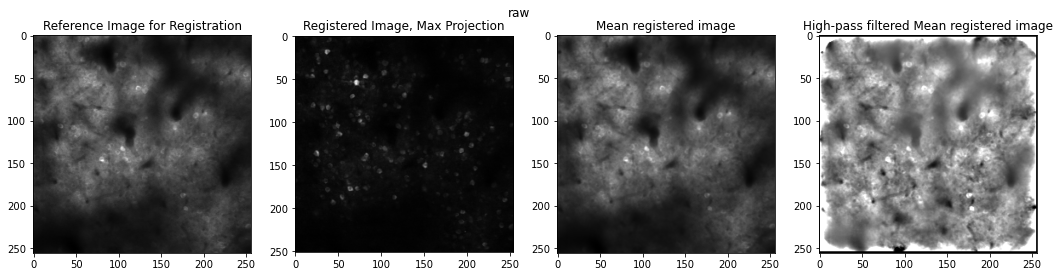

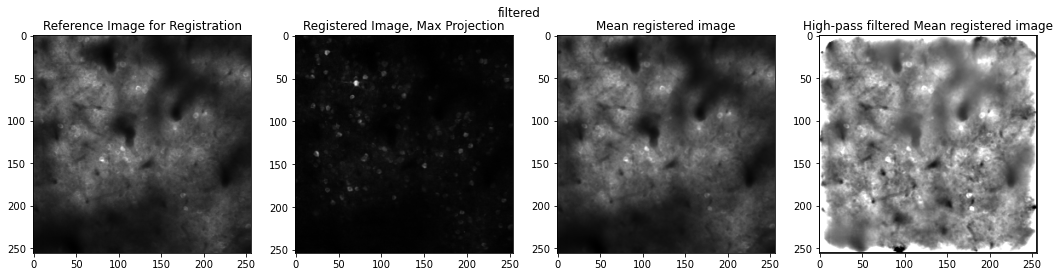

In [12]:
for k, v in output_ops.items():
    plot_suite2p_registration_images(v, title=k)

### Plot suite2p registration offsets

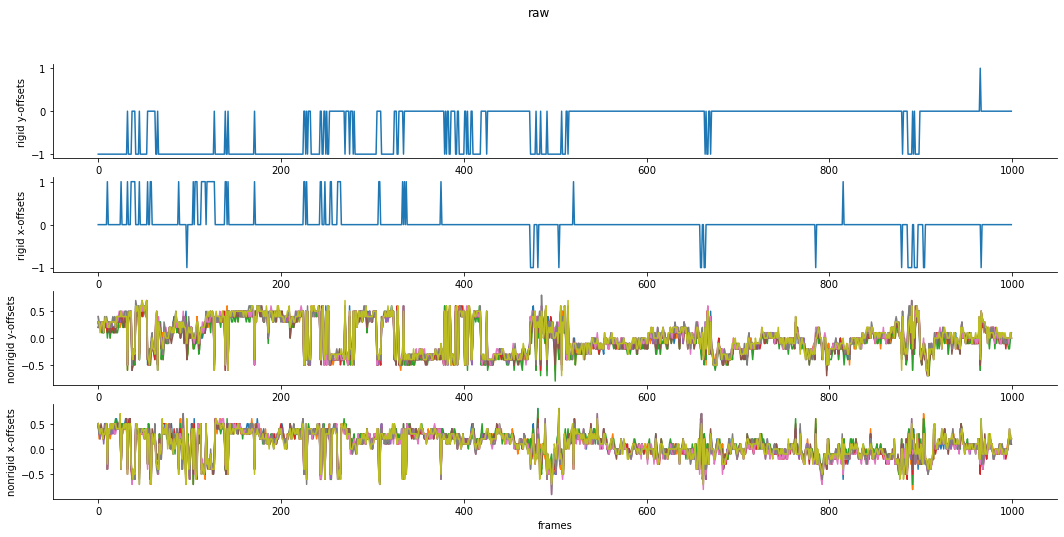

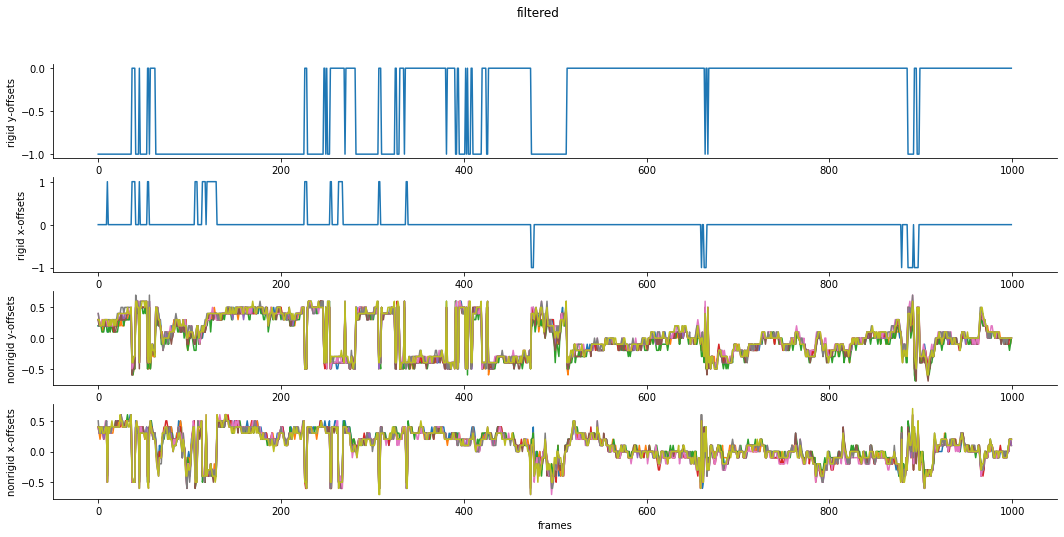

In [13]:
for k, v in output_ops.items():
    plot_suite2p_registration_offsets(v, title=k)

### Visualize registered stack

In [36]:
for k, v in output_ops.items():
    view_registered_stack(output_ops[k])

interactive(children=(IntSlider(value=800, description='t', max=1600), Output()), _dom_classes=('widget-intera…

interactive(children=(IntSlider(value=800, description='t', max=1600), Output()), _dom_classes=('widget-intera…

### Load suite2p ouput data

In [49]:
data = {k: get_suite2p_data(v['save_path']) for k, v in output_ops.items()}

### Inspect suite2p ROIs

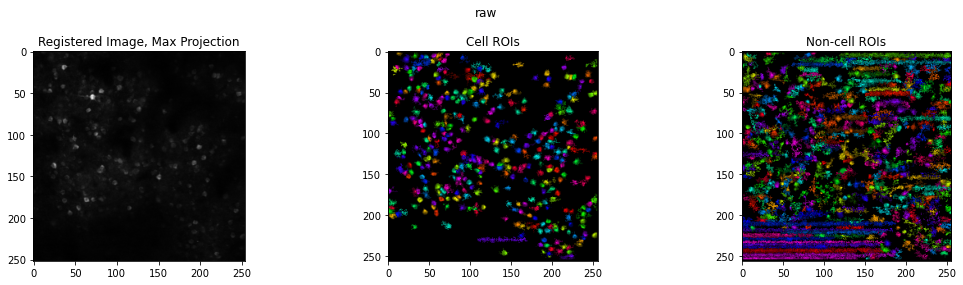

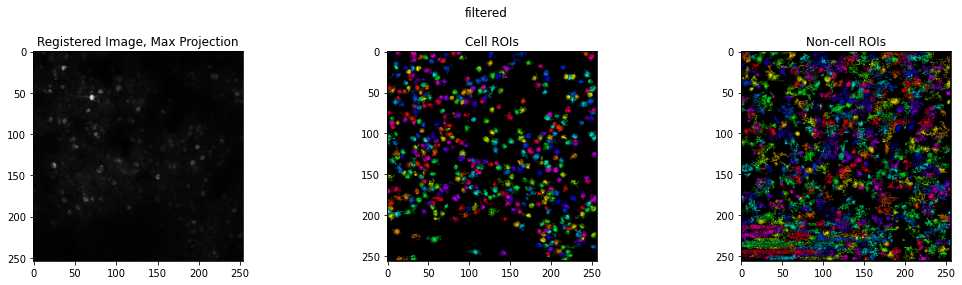

In [54]:
for k, v in output_ops.items():
    fig = plot_suite2p_ROIs(data[k], v, title=k)

### Filter out non-cell ROIs

In [57]:
cell_data = {}
for k, v in data.items():
    iscell = v['iscell'][:, 0]  # the full "iscell" has a second column with the probability of being a cell
    cell_idx = np.array(iscell.nonzero()).reshape(-1)
    cell_data[k] = {key : val[cell_idx] for key, val in v.items()}
    del cell_data[k]['iscell']

### Compute fluorescence data

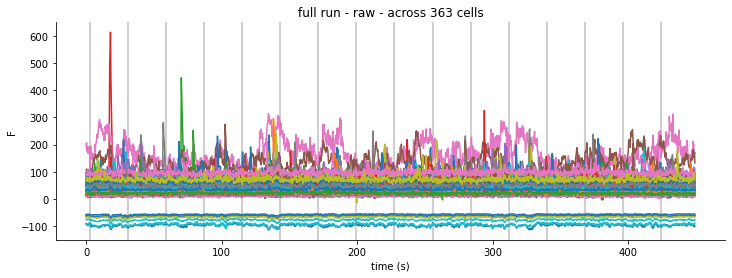

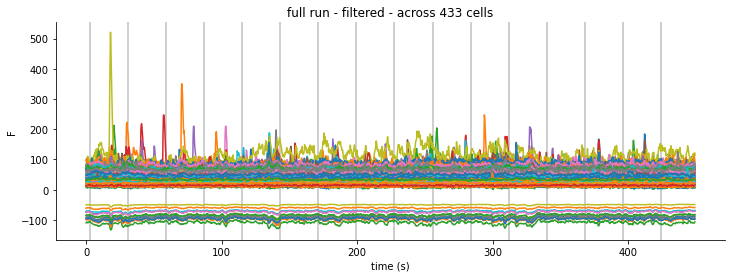

In [58]:
F = {k: v['F'] - NEUROPIL_FACTOR * v['Fneu'] for k, v in cell_data.items()}
for k, v in F.items():
    fig = plot_run(v, FPS, 'F', title=f'{k} - across {v.shape[0]} cells', mark_stim=True)

### Split the data into separate trials 

In [59]:
F_pertrial = {k: separate_trials(v, NTRIALS_PER_RUN) for k, v in F.items()}

### Compute relative fluorescence change for each trial

In [60]:
# Define indexes used for baseline computation per trial
# omit first second (not sure what's up with the data there) -> start at -7 instead of -10
ibaseline = slice(STIM_FRAME_INDEX-7,STIM_FRAME_INDEX-1) 

# Compute relative fluorescence change
dFF_pertrial = {k: get_relative_fluorescence_change(v, ibaseline) for k, v in F_pertrial.items()}

# assume peak response happens within 1 second of stimulation. Hence 3 first frames after stim
# poststim = slice(STIM_FRAME_INDEX+1, STIM_FRAME_INDEX+7) 

### Plot Calcium transients for a particular cell

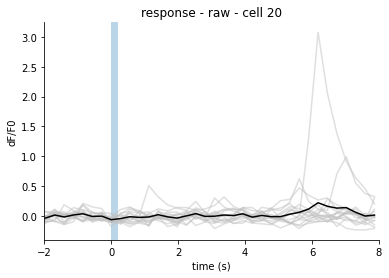

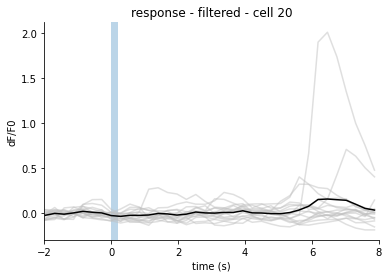

In [61]:
cell_id = 20
tstim = exp_params['duration']
for k, v in dFF_pertrial.items():
    fig = plot_response(v[cell_id], FPS, title=f'{k} - cell {cell_id}', ylabel='dF/F0', avgmode=True, tstim=tstim)

### Plot average Calcium transients across cells

(363, 100)
(433, 100)


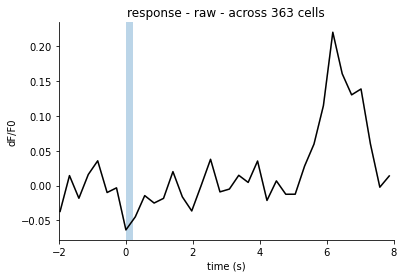

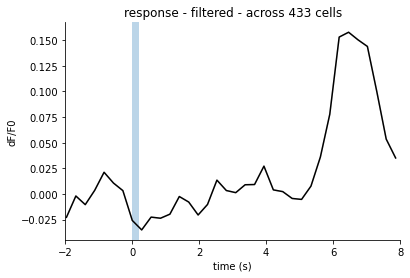

In [62]:
# Average fluorescence data across trials
dFF_trialavg = {k: v.mean(axis=1) for k, v in dFF_pertrial.items()}
for k, v in dFF_trialavg.items():
    print(v.shape)
    fig = plot_response(v[cell_id], FPS, title=f'{k} - across {v.shape[0]} cells', ylabel='dF/F0', avgmode=True, tstim=tstim)